In [1]:
# PHYS302/CS686-06
# HW2 XOR, Fully-Connected ANN, and Nonlinear Boundaries
# Logan Jendrusch
# Prof. Xiaosheng Huang

%matplotlib inline
from random import choice
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def sigmoid(x):
    return 1./(1. + np.exp(-x))

def sigmoid_prime(x):
    return x*(1.-x)

def tanh(x):
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

def tanh_prime(x):
    return 1.-x**2

In [3]:
class NeuralNetwork:
    # nn must have at least one hidden layer
    # assuming all hidden layers have same number neurons
    def __init__(self, layers, activation='sigmoid'):
        # number hidden layers
        self.n_h = len(layers)-2
        # hidden layer(s) weights and biases
        self.h_ws = np.random.uniform(size=(self.n_h, layers[0], layers[0]))
        self.h_bs = np.random.uniform(size=(self.n_h, 1, layers[0]))
        # output layer weights and bias
        self.o_ws = np.random.uniform(size=(layers[0], layers[-1]))
        self.o_bs = np.random.uniform(size=(1, layers[-1]))
        self.act = lambda x : sigmoid(x) if activation=='sigmoid' else tanh(x)
        self.act_prime = lambda x : sigmoid_prime(x) if activation=='sigmoid' else tanh_prime(x)

    def predict(self, x):
        return self.f_prop(x)[1]
    
    def f_prop(self, X):
        A = [self.act(np.dot(X, self.h_ws[0])+self.h_bs[0])]
        for i in range(1, self.n_h):
            A.append(self.act(np.dot(A[-1], self.h_ws[i])+self.h_bs[i]))
        z = self.act(np.dot(A[-1], self.o_ws)+self.o_bs)
        return np.array(A), z

    def b_prop(self, X, A, prediction, target, lr):
        c = target - prediction
        d_L = (c)*self.act_prime(prediction)
        d_m = [np.dot(d_L, self.o_ws.T)*self.act_prime(A[-1])]
        for i in range(self.n_h-1,0,-1):
            d_m.append(np.dot(d_m[-1], self.h_ws[i].T)*self.act_prime(A[i-1]))
        d_m.reverse()

        self.o_ws += np.dot(A[-1].T, d_L)*lr
        self.o_bs += np.sum(d_L,axis=0,keepdims=True)*lr

        self.h_ws[0] += np.dot(X.T, d_m[0])*lr
        self.h_bs[0] += np.sum(d_m[0],axis=0,keepdims=True)*lr

        for i in range(1, self.n_h):
            self.h_ws[i] += np.dot(A[i].T, d_m[i])*lr
            self.h_bs[i] += np.sum(d_m[i],axis=0,keepdims=True)*lr
        return c
        
    def fit(self, X, target, lr=.2, steps=100000, tol=1e-2):
        target = target.reshape(target.shape[0],1)
        costs = []
        success = False
        for i in range(steps):
            A, prediction = self.f_prop(X)
            c = self.b_prop(X, A, prediction, target, lr)
            # c is a (4,1) np array of z-y's
            costs.append(c)
            if i == 0:
                self.text_report(i, X, target, [costs[-1]])
            elif (i+1) % (steps/10) == 0:
                self.text_report(i, X, target, [costs[-1]])
                self.graph_report(i, steps, costs)
                if self.find_RMS_error([costs[-1]])[0] <= tol:
                    success = True
                    break
        print('NN training {}'.format('succeeded!' if success else 'failed.'))
        self.graph_smoothed_loss(np.array(costs))
        self.visual_NN_boundaries()

    def text_report(self, i, X, target, c):
        print('\nstep: {:d}'.format(i+1))
        print('Training Results(data, prediction, expected):')
        for i in range(len(X)):
            print('{}, {:.4f}, {:d}'.format(X[i], self.predict(X[i])[0,0], target[i,0]))
        print('RMS_err: {:.5f}'.format(self.find_RMS_error(c)[0]))

    def graph_report(self, i, steps, costs):
        plt.plot(self.find_RMS_error(costs))
        plt.xlim(0,steps)
        plt.title('RMS Error [0:{:d}]'.format(i+1))
        plt.show()

    def graph_smoothed_loss(self, costs):
        # f_loss = -.5*sum((y_k-z_k)**2)
        losses = [-.5*np.sum(costs[i]**2) for i in range(len(costs))]
        factor = 10
        smoothed = [sum(losses[i:i+factor])/factor for i in range(len(losses)-factor)]
        plt.plot(smoothed)
        plt.title('Smoothed Loss')
        plt.show()

    def find_RMS_error(self, costs):
        return np.array([np.sqrt(np.mean(np.square(c))) for c in costs])

    def visual_NN_boundaries(self, Nsamp=2000):
        dim = 101
        xs = []
        ys = []
        for i in range(dim):
            for j in range(dim):
                xs.append(i/(dim-1))
                ys.append(j/(dim-1))
        xs = np.array(xs)
        ys = np.array(ys)
        zs = np.array([1 if self.predict(np.array([x,y]))[0,0] >= .5 else 0 for x,y in zip(xs,ys)])
        plt.scatter(xs[zs==1],ys[zs==1])
        plt.scatter(xs[zs==0],ys[zs==0])
        plt.show()


step: 1
Training Results(data, prediction, expected):
[0 0], 0.7307, 0
[0 1], 0.7501, 1
[1 0], 0.7678, 1
[1 1], 0.7815, 0
RMS_err: 0.56744

step: 1000
Training Results(data, prediction, expected):
[0 0], 0.4342, 0
[0 1], 0.5254, 1
[1 0], 0.5259, 1
[1 1], 0.5533, 0
RMS_err: 0.48606


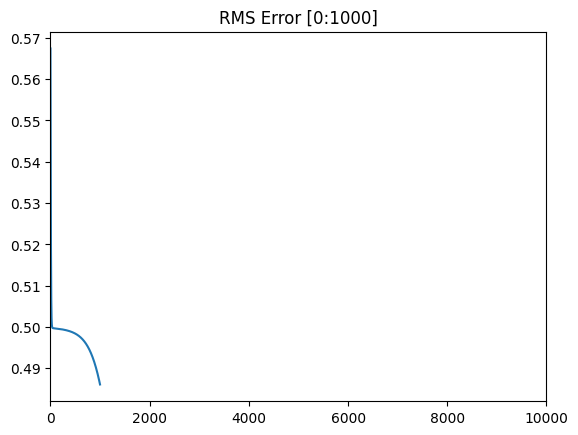


step: 2000
Training Results(data, prediction, expected):
[0 0], 0.2060, 0
[0 1], 0.6925, 1
[1 0], 0.6858, 1
[1 1], 0.4288, 0
RMS_err: 0.32430


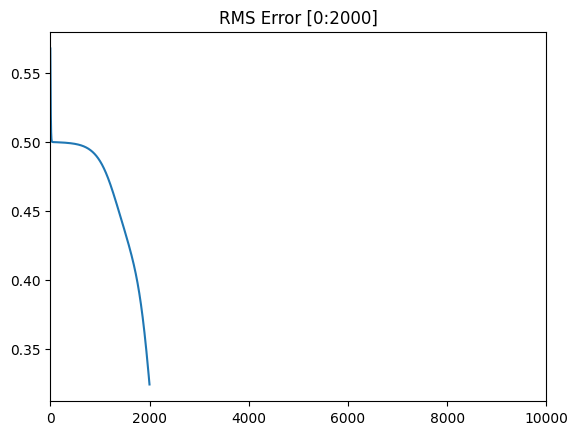


step: 3000
Training Results(data, prediction, expected):
[0 0], 0.1036, 0
[0 1], 0.8956, 1
[1 0], 0.8958, 1
[1 1], 0.1180, 0
RMS_err: 0.10778


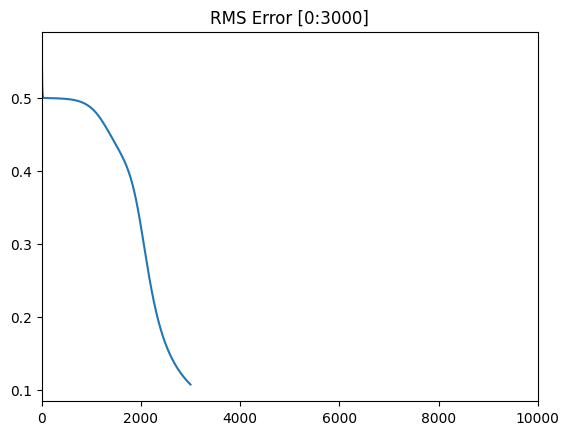


step: 4000
Training Results(data, prediction, expected):
[0 0], 0.0715, 0
[0 1], 0.9325, 1
[1 0], 0.9326, 1
[1 1], 0.0737, 0
RMS_err: 0.07007


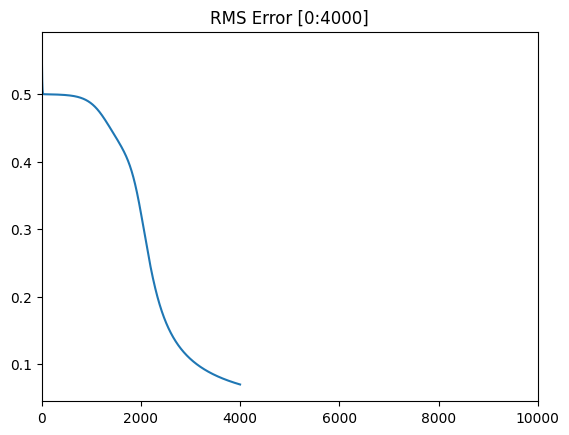


step: 5000
Training Results(data, prediction, expected):
[0 0], 0.0572, 0
[0 1], 0.9474, 1
[1 0], 0.9475, 1
[1 1], 0.0566, 0
RMS_err: 0.05479


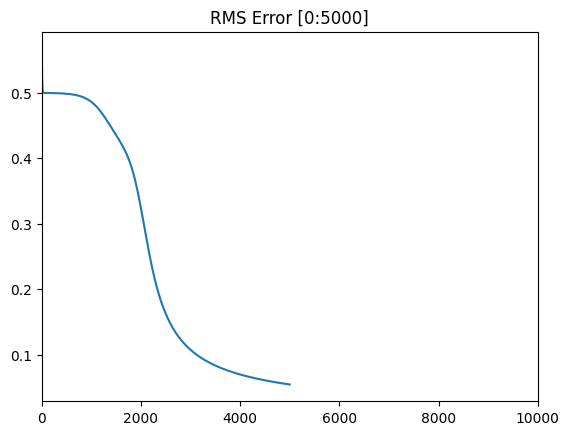


step: 6000
Training Results(data, prediction, expected):
[0 0], 0.0488, 0
[0 1], 0.9557, 1
[1 0], 0.9558, 1
[1 1], 0.0472, 0
RMS_err: 0.04619


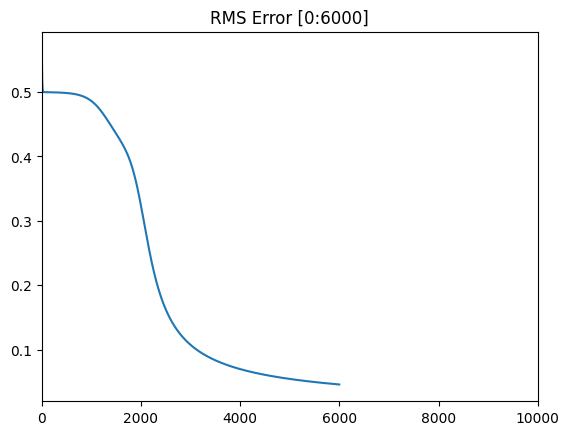


step: 7000
Training Results(data, prediction, expected):
[0 0], 0.0432, 0
[0 1], 0.9612, 1
[1 0], 0.9612, 1
[1 1], 0.0412, 0
RMS_err: 0.04054


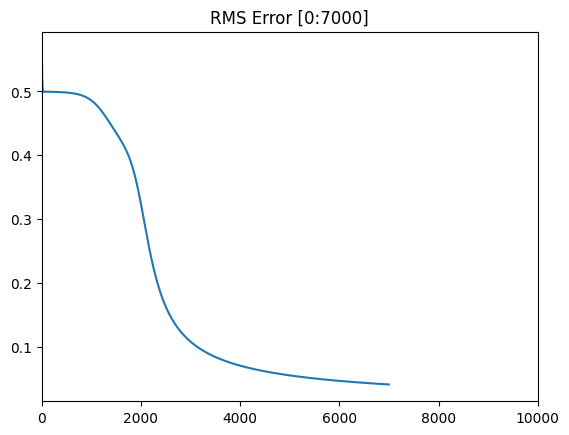


step: 8000
Training Results(data, prediction, expected):
[0 0], 0.0391, 0
[0 1], 0.9651, 1
[1 0], 0.9651, 1
[1 1], 0.0369, 0
RMS_err: 0.03649


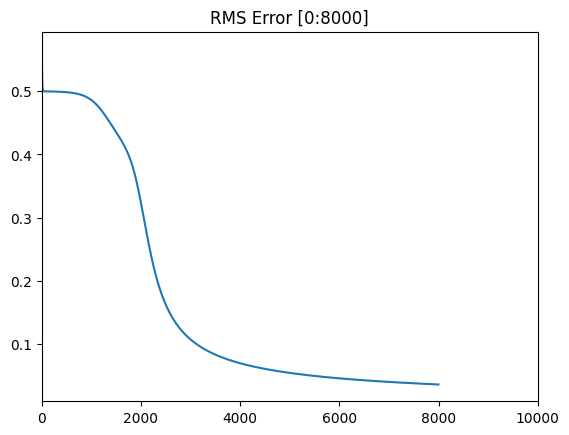


step: 9000
Training Results(data, prediction, expected):
[0 0], 0.0360, 0
[0 1], 0.9681, 1
[1 0], 0.9681, 1
[1 1], 0.0336, 0
RMS_err: 0.03342


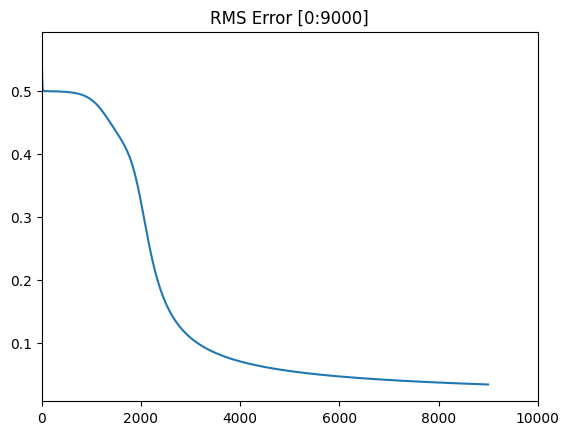


step: 10000
Training Results(data, prediction, expected):
[0 0], 0.0335, 0
[0 1], 0.9704, 1
[1 0], 0.9704, 1
[1 1], 0.0311, 0
RMS_err: 0.03098


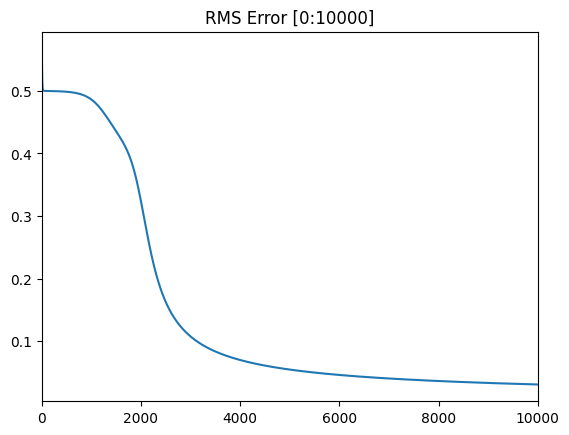

NN training failed.


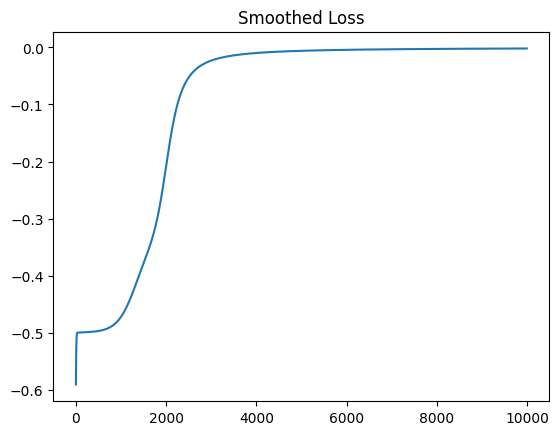

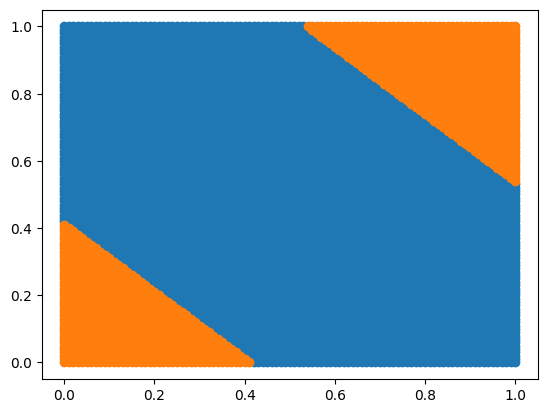

In [4]:
nn = NeuralNetwork([2,2,1])

X = np.array([[0,0],
             [0,1],
             [1,0],
             [1,1]])

y = np.array([0,1,1,0])

nn.fit(X,y,steps=10000)


step: 1
Training Results(data, prediction, expected):
[0. 0.], 0.6645, 0
[0. 1.], 0.6691, 0
[0.5 1. ], 0.6799, 0
[0.  0.5], 0.6668, 1
[1. 0.], 0.6855, 1
[1. 1.], 0.6887, 1
RMS_err: 0.53232

step: 1000
Training Results(data, prediction, expected):
[0. 0.], 0.2742, 0
[0. 1.], 0.2149, 0
[0.5 1. ], 0.3245, 0
[0.  0.5], 0.2344, 1
[1. 0.], 0.9547, 1
[1. 1.], 0.8293, 1
RMS_err: 0.37508


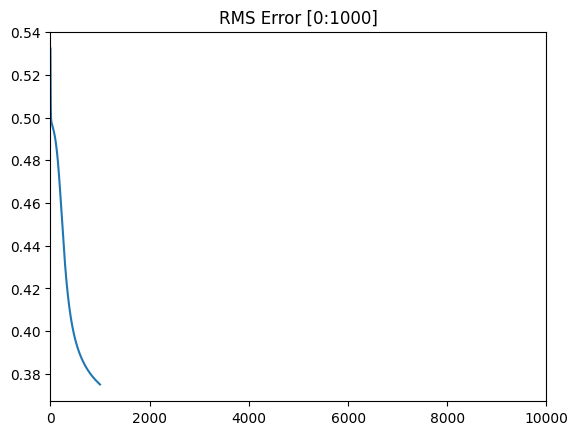


step: 2000
Training Results(data, prediction, expected):
[0. 0.], 0.2689, 0
[0. 1.], 0.2228, 0
[0.5 1. ], 0.2796, 0
[0.  0.5], 0.2402, 1
[1. 0.], 0.9838, 1
[1. 1.], 0.8894, 1
RMS_err: 0.36285


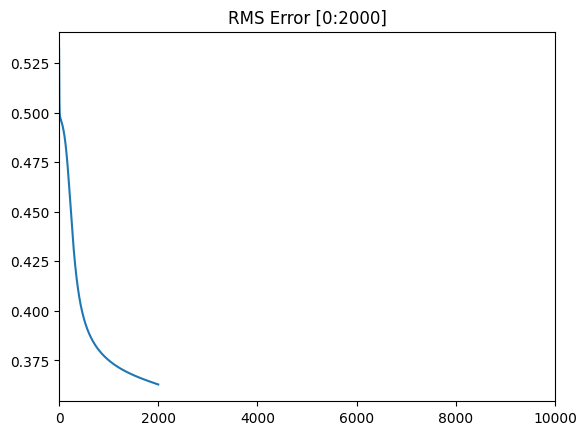


step: 3000
Training Results(data, prediction, expected):
[0. 0.], 0.3092, 0
[0. 1.], 0.2304, 0
[0.5 1. ], 0.2335, 0
[0.  0.5], 0.2661, 1
[1. 0.], 0.9892, 1
[1. 1.], 0.9124, 1
RMS_err: 0.35350


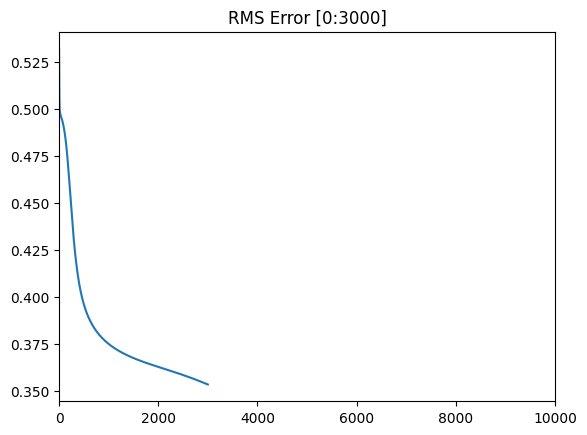


step: 4000
Training Results(data, prediction, expected):
[0. 0.], 0.3648, 0
[0. 1.], 0.2438, 0
[0.5 1. ], 0.1659, 0
[0.  0.5], 0.3055, 1
[1. 0.], 0.9886, 1
[1. 1.], 0.9255, 1
RMS_err: 0.34354


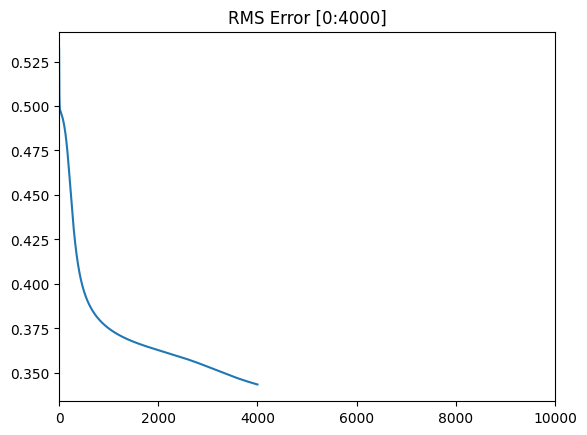


step: 5000
Training Results(data, prediction, expected):
[0. 0.], 0.4004, 0
[0. 1.], 0.2413, 0
[0.5 1. ], 0.1166, 0
[0.  0.5], 0.3336, 1
[1. 0.], 0.9898, 1
[1. 1.], 0.9374, 1
RMS_err: 0.33673


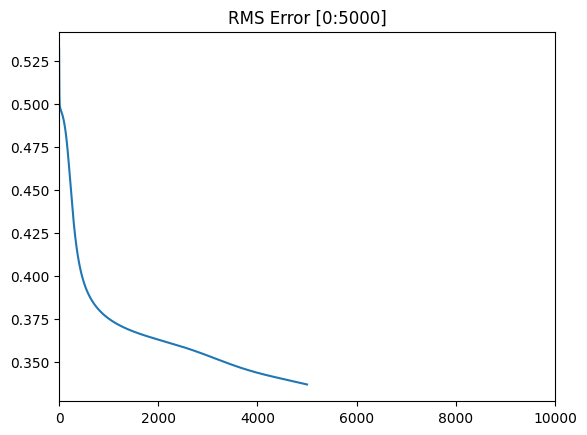


step: 6000
Training Results(data, prediction, expected):
[0. 0.], 0.4349, 0
[0. 1.], 0.2148, 0
[0.5 1. ], 0.0826, 0
[0.  0.5], 0.3680, 1
[1. 0.], 0.9949, 1
[1. 1.], 0.9478, 1
RMS_err: 0.32770


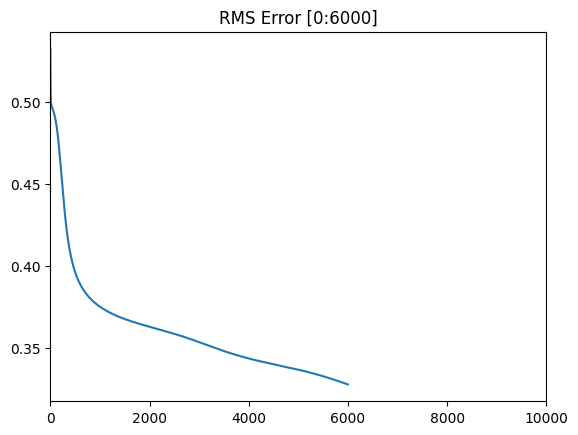


step: 7000
Training Results(data, prediction, expected):
[0. 0.], 0.4672, 0
[0. 1.], 0.1730, 0
[0.5 1. ], 0.0589, 0
[0.  0.5], 0.4100, 1
[1. 0.], 0.9983, 1
[1. 1.], 0.9550, 1
RMS_err: 0.31672


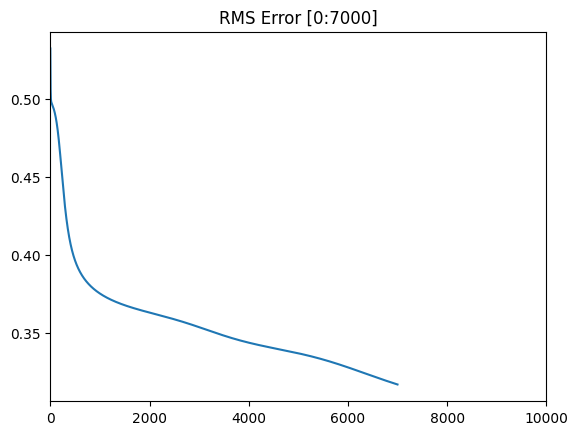


step: 8000
Training Results(data, prediction, expected):
[0. 0.], 0.4846, 0
[0. 1.], 0.1376, 0
[0.5 1. ], 0.0451, 0
[0.  0.5], 0.4404, 1
[1. 0.], 0.9993, 1
[1. 1.], 0.9594, 1
RMS_err: 0.30838


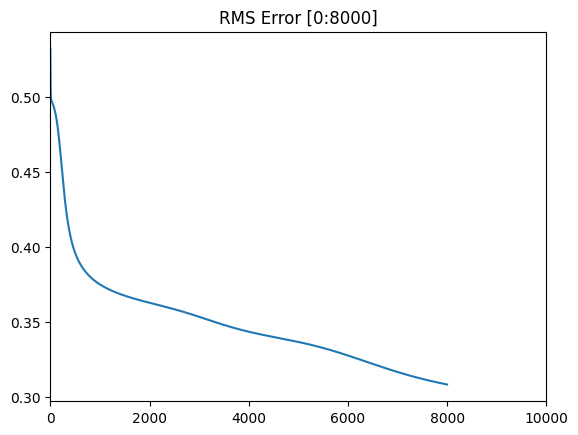


step: 9000
Training Results(data, prediction, expected):
[0. 0.], 0.4922, 0
[0. 1.], 0.1134, 0
[0.5 1. ], 0.0372, 0
[0.  0.5], 0.4582, 1
[1. 0.], 0.9996, 1
[1. 1.], 0.9627, 1
RMS_err: 0.30318


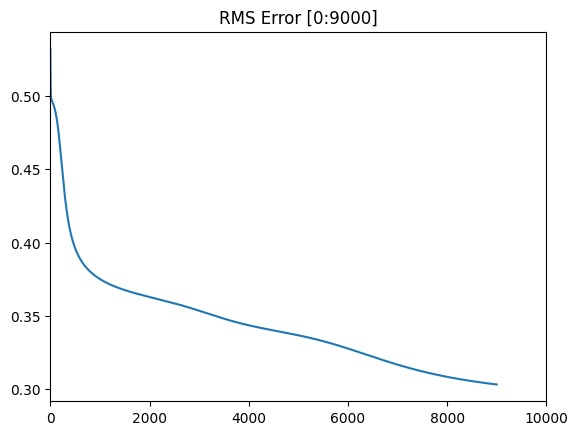


step: 10000
Training Results(data, prediction, expected):
[0. 0.], 0.4957, 0
[0. 1.], 0.0970, 0
[0.5 1. ], 0.0324, 0
[0.  0.5], 0.4687, 1
[1. 0.], 0.9997, 1
[1. 1.], 0.9654, 1
RMS_err: 0.29991


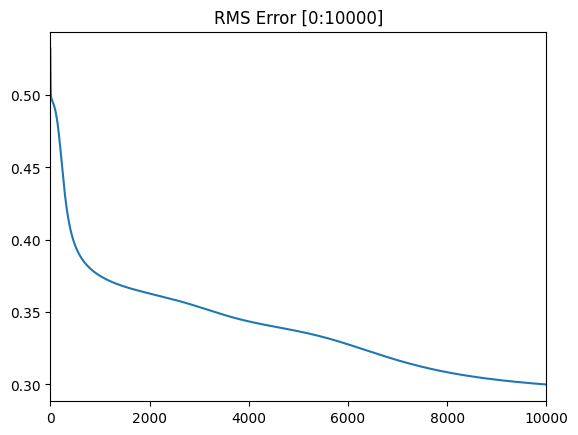

NN training failed.


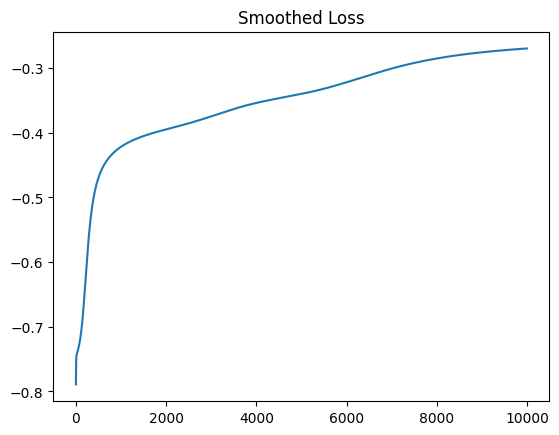

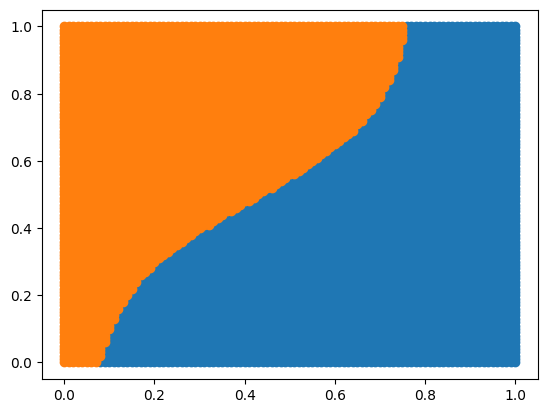

In [5]:
nn = NeuralNetwork([2,3,1])

X = np.array([[0, 0],
            [0, 1],
            [0.5, 1],
            [0, 0.5],
            [1, 0],
            [1, 1]])

y = np.array([0, 0, 0, 1, 1, 1])

nn.fit(X,y,steps=10000)